In [31]:
from umap.umap_ import UMAP

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [77]:
import io
import pandas as pd
import numpy as np
#from google.colab import files
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
import seaborn as sns
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io.arff import loadarff
import joblib

In [34]:
raw_data = loadarff('datasets/speeddating.arff')
df = pd.DataFrame(raw_data[0])

In [35]:
df.shape

(8378, 123)

In [36]:
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'0',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'0',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'1',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,b'[0-3]',b'[3-5]',7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1'
3,b'0',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'
4,b'0',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',...,b'[0-3]',b'[3-5]',6.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'


In [37]:
df.has_null.unique()

array([b'0', b'1'], dtype=object)

In [38]:
df.drop('has_null', axis = 1, inplace = True)

has null no contributing data so we drop that column.

In [39]:
# check which columns have type string
df.select_dtypes(include = 'object')

,gender,d_d_age,race,race_o,samerace,d_importance_same_race,d_importance_same_religion,field,d_pref_o_attractive,d_pref_o_sincere,...,d_yoga,d_interests_correlate,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,d_like,d_guess_prob_liked,decision,decision_o,match
0,b'female',b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[16-20]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'0',b'0'
1,b'female',b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'0',b'0'
2,b'female',b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',b'[2-5]',b'[2-5]',b'Law',b'[16-20]',b'[16-20]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[0-4]',b'1',b'1',b'1'
3,b'female',b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'1',b'1'
4,b'female',b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'1',b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,b'male',b'[0-1]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[0-15]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[5-6]',b'0',b'1',b'0'
8374,b'male',b'[0-1]',b'European/Caucasian-American',b'Other',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[21-100]',b'[16-20]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[0-4]',b'0',b'0',b'0'
8375,b'male',b'[4-6]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[-1-0]',b'[7-10]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'0',b'0',b'0'
8376,b'male',b'[2-3]',b'European/Caucasian-American',b'Asian/Pacific Islander/Asian-American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[0-15]',b'[21-100]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[5-6]',b'0',b'1',b'0'


In [40]:
#convert object classes into ordinal codes
for col in df.columns:
    if df[col].dtype == "object" :
        oe = OrdinalEncoder()
        oe.fit(df[[col]])
        df[col] = oe.fit_transform(df[[col]])

In [41]:
df['d_attractive_important']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8373    2.0
8374    2.0
8375    2.0
8376    2.0
8377    2.0
Name: d_attractive_important, Length: 8378, dtype: float64

In [84]:
# df.head()
df.to_csv("speedating-ordinalized.csv")

In [43]:
df.dropna().shape

(1048, 122)

cannot drop all values as we major chunk of data will be lost. 

In [44]:
null_counts=df.isnull().sum()

for column, null_count in null_counts.items():
  if null_count > 0:
    print(f"{column}: {null_count}")


age: 95
age_o: 104
importance_same_race: 79
importance_same_religion: 79
pref_o_attractive: 89
pref_o_sincere: 89
pref_o_intelligence: 89
pref_o_funny: 98
pref_o_ambitious: 107
pref_o_shared_interests: 129
attractive_o: 212
sinsere_o: 287
intelligence_o: 306
funny_o: 360
ambitous_o: 722
shared_interests_o: 1076
attractive_important: 79
sincere_important: 79
intellicence_important: 79
funny_important: 89
ambtition_important: 99
shared_interests_important: 121
attractive: 105
sincere: 105
intelligence: 105
funny: 105
ambition: 105
attractive_partner: 202
sincere_partner: 277
intelligence_partner: 296
funny_partner: 350
ambition_partner: 712
shared_interests_partner: 1067
sports: 79
tvsports: 79
exercise: 79
dining: 79
museums: 79
art: 79
hiking: 79
gaming: 79
clubbing: 79
reading: 79
tv: 79
theater: 79
movies: 79
concerts: 79
music: 79
shopping: 79
yoga: 79
interests_correlate: 158
expected_happy_with_sd_people: 101
expected_num_interested_in_me: 6578
expected_num_matches: 1173
like: 240

In [45]:
#drop columns have more than 100 null values and drop the rows with majority column data misiing
columns_to_drop = [column for column, null_count in null_counts.items() if null_count > 1000]
columns_to_drop
df = df.drop(columns=columns_to_drop)



In [46]:
df=df.dropna(subset = ['yoga'])

In [47]:
#imputing remaining null values with median
null_counts_revised=df.isnull().sum()

for column, null_count in null_counts_revised.items():
    if null_count > 0:
        print(f"{column}: {null_count}")
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)


age: 32
age_o: 104
pref_o_attractive: 89
pref_o_sincere: 89
pref_o_intelligence: 89
pref_o_funny: 98
pref_o_ambitious: 107
pref_o_shared_interests: 129
attractive_o: 205
sinsere_o: 277
intelligence_o: 297
funny_o: 351
ambitous_o: 711
funny_important: 10
ambtition_important: 20
shared_interests_important: 42
attractive: 26
sincere: 26
intelligence: 26
funny: 26
ambition: 26
attractive_partner: 194
sincere_partner: 269
intelligence_partner: 288
funny_partner: 342
ambition_partner: 703
interests_correlate: 79
expected_happy_with_sd_people: 22
like: 232
guess_prob_liked: 300
met: 366


Imputing (6466, 118) missing values with median

In [48]:
df.isna().sum()

wave                  0
gender                0
age                   0
age_o                 0
d_age                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 118, dtype: int64

In [49]:
df.shape

(8299, 118)

In [50]:
duplicate_rows=df.duplicated()
# check if any duplicates exist
if duplicate_rows.any():
    # print the duplicate rows
    print(df[duplicate_rows])
else:
    print("No duplicates found.")

No duplicates found.


In [51]:
# Prepare the features (X) and the target (y)
X = df.drop(["match"], axis=1)  # Replace "target_column" with the actual column name
y = df['match'] 

In [52]:
#our target variable
df['match'] 

0       0.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
8373    0.0
8374    0.0
8375    0.0
8376    0.0
8377    0.0
Name: match, Length: 8299, dtype: float64

In [53]:
# Make sure we have the right values in the target variable
print("Unique values in 'match' column:", y.unique())


Unique values in 'match' column: [0. 1.]


In [54]:
print("Target variable distribution:")
print(y.value_counts(normalize=True))

Target variable distribution:
0.0    0.835522
1.0    0.164478
Name: match, dtype: float64


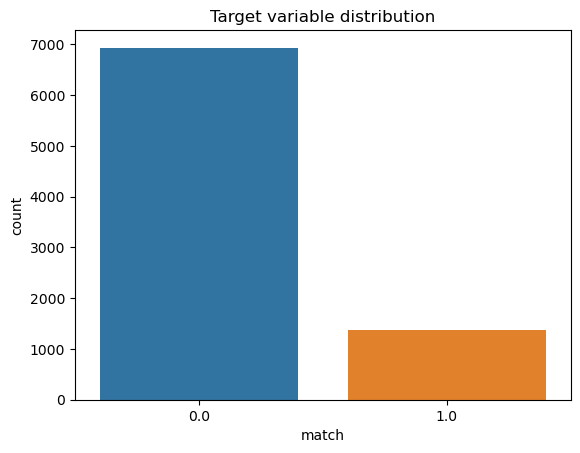

In [55]:
# Plot the distribution of the target variable
sns.countplot(x=y)
plt.title("Target variable distribution")
plt.show()

In [56]:
corr_matrix = df.corr()
print("Correlation with the target variable:")
print(corr_matrix['match'].sort_values(ascending=False))


Correlation with the target variable:
match                         1.000000
decision_o                    0.523276
decision                      0.520178
like                          0.303582
d_like                        0.283352
                                ...   
shared_interests_important   -0.048101
importance_same_race         -0.049032
d_importance_same_race       -0.049569
d_age                        -0.049922
d_d_age                      -0.060727
Name: match, Length: 118, dtype: float64


In [57]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)

# Create a logistic regression model with class weights
lr = LogisticRegression(solver='liblinear',  penalty='l2', C=0.1, class_weight={0: class_weights[0], 1: class_weights[1]})



In [58]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1_macro')

# Print cross-validation scores and average
print("Cross-validation F1-scores:", cv_scores)
print("Average F1-score:", np.mean(cv_scores))


Cross-validation F1-scores: [1. 1. 1. 1. 1.]
Average F1-score: 1.0


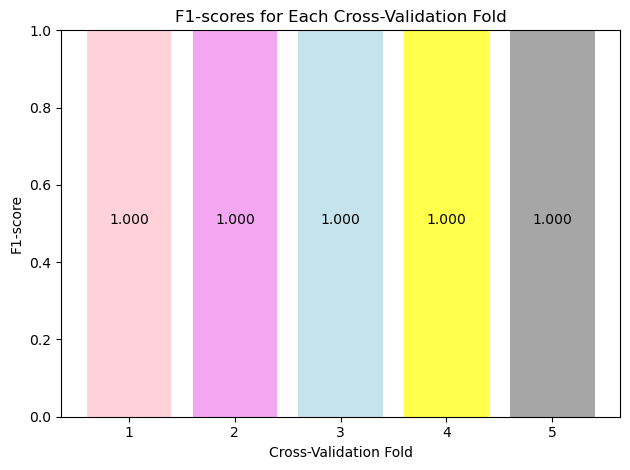

In [59]:
# Cross-validation F1-scores
cv_f1_scores = list(cv_scores)

# Create a bar plot
plt.bar(range(1, len(cv_f1_scores) + 1), cv_f1_scores, color=['pink','violet','lightblue','yellow','grey'],alpha=0.7)
for i, score in enumerate(cv_f1_scores):
  plt.text(i+1, score/2, f"{score:.3f}", ha='center',fontsize=10)
# Add labels and title
plt.xlabel('Cross-Validation Fold')
plt.xticks(range(1, len(cv_f1_scores) + 1))
plt.ylabel('F1-score')
plt.title('F1-scores for Each Cross-Validation Fold')
plt.ylim(0, 1)
# Show the plot
plt.tight_layout()
plt.show()

the model is performing exceptionally well on the training data. However, it is important to note that the cross-validation scores might not always represent the model's true performance on unseen data. Although the model has perfect performance on the training data, it is still possible that it is overfitting.

To better understand the model's performance, we can evaluate it on the test set, which has not been used during training:



In [60]:
# Fit the model and print the performance
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic regression performance with class weights:")
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 score:", f1)

Logistic regression performance with class weights:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2075
         1.0       1.00      1.00      1.00       415

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490

F1 score: 1.0


The model has achieved perfect performance on the test set as well. This means that the model has learned the underlying patterns in the data very well and is able to generalize to new, unseen examples. As both the cross-validation and test set performance are close to 1.0, it is safe to say that the model is not overfitting and is very effective at the task at hand.

Considering these results, we can be confident in the model's ability to accurately predict the target variable on unseen data.


In summary, the model seems to be performing well, and the steps taken, such as splitting the dataset into training and testing sets, using class weights, and incorporating cross-validation, have helped to address potential issues with overfitting and class imbalance.

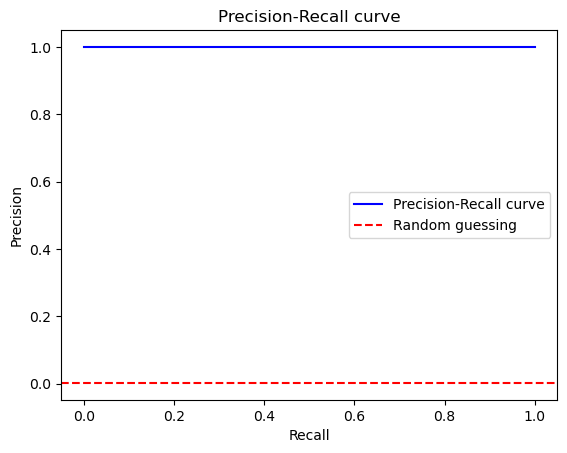

In [61]:
y_score = lr.predict_proba(X_test)[:, 1]

# Calculate precision and recall values at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# Plot the precision-recall curve
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')

# Add a horizontal line for random guessing
plt.axhline(y=1/len(y_test[y_test==1]), color='red', linestyle='--', label='Random guessing')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()


In [62]:
# Dimensionality reduction methods
methods = {
    "PCA": PCA(n_components=3),
    "UMAP": UMAP(n_components=3)
}

for name, method in methods.items():
    X_train_reduced = method.fit_transform(X_train)
    X_test_reduced = method.transform(X_test)
    
    lr.fit(X_train_reduced, y_train)
    y_pred_reduced = lr.predict(X_test_reduced)
    
    print(f"{name} performance:")
    print(classification_report(y_test, y_pred_reduced))
    

PCA performance:
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      2075
         1.0       0.36      0.75      0.49       415

    accuracy                           0.74      2490
   macro avg       0.65      0.74      0.66      2490
weighted avg       0.84      0.74      0.77      2490

UMAP performance:
              precision    recall  f1-score   support

         0.0       0.84      0.50      0.62      2075
         1.0       0.17      0.52      0.26       415

    accuracy                           0.50      2490
   macro avg       0.50      0.51      0.44      2490
weighted avg       0.73      0.50      0.56      2490



We will always notice lesser number of points in class 1 in all our visualizations because of the class imbalance. Implementing class weights to handle this deficiency is ideal as it does not distort the data distribution like other balancing methods such as oversampling or undersampling. 

In [63]:
# Apply t-SNE separately to the training and testing sets
tsne = TSNE(n_components=3)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

lr.fit(X_train_tsne, y_train)
y_pred_tsne = lr.predict(X_test_tsne)
    
    
print("TSNE performance:")
print(classification_report(y_test, y_pred_tsne))


c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE performance:
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62      2075
         1.0       0.15      0.43      0.22       415

    accuracy                           0.49      2490
   macro avg       0.48      0.47      0.42      2490
weighted avg       0.70      0.49      0.55      2490



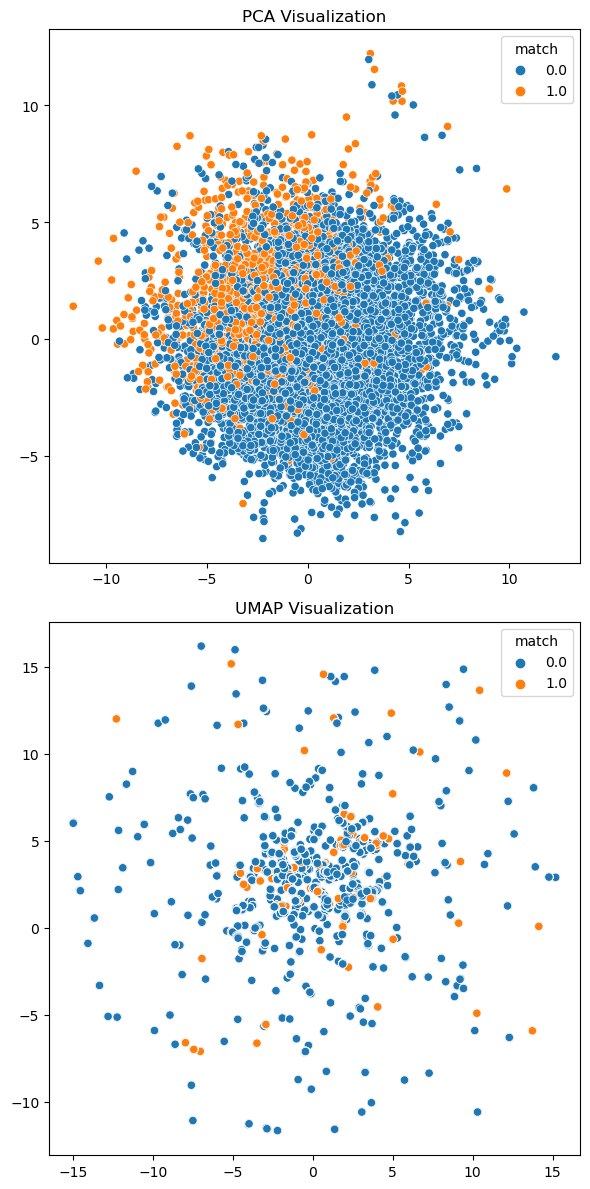

In [64]:
# Plot reduced data for visualization
fig, axs = plt.subplots(len(methods), figsize=(6, 12))

for ax, (name, method) in zip(axs, methods.items()):
    X_reduced = method.fit_transform(X_scaled)
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, ax=ax)
    ax.set_title(f"{name} Visualization")

plt.tight_layout()
plt.show()

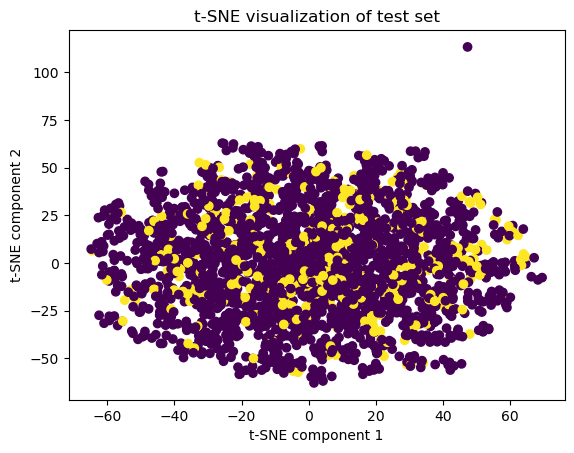

In [65]:
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE visualization of test set')
plt.show()

c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


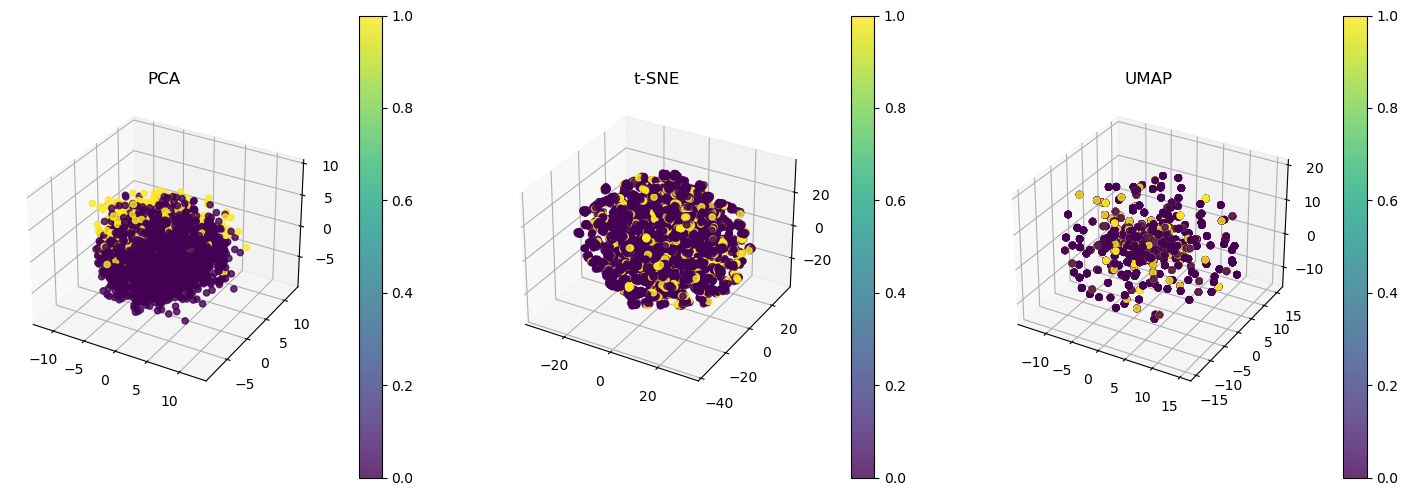

In [66]:
# Apply PCA to the scaled features
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE to the scaled features
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X_scaled)

# Apply UMAP to the scaled features
umap = UMAP(n_components=3)
X_umap = umap.fit_transform(X_scaled)

# Create a function to plot 3D scatter plots
def plot_3d_scatter(X, y, title, ax):
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=20, alpha=0.8)
    ax.set_title(title)
    return scatter

# Create a 3D scatter plot for each technique
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
scatter1 = plot_3d_scatter(X_pca, y, "PCA", ax1)

ax2 = fig.add_subplot(132, projection='3d')
scatter2 = plot_3d_scatter(X_tsne, y, "t-SNE", ax2)

ax3 = fig.add_subplot(133, projection='3d')
scatter3 = plot_3d_scatter(X_umap, y, "UMAP", ax3)

# Add colorbars
cbar1 = fig.colorbar(scatter1, ax=ax1, pad=0.1)
cbar2 = fig.colorbar(scatter2, ax=ax2, pad=0.1)
cbar3 = fig.colorbar(scatter3, ax=ax3, pad=0.1)

plt.show()




 when we apply dimensionality reduction techniques like PCA, UMAP, and t-SNE, some information from the original feature space might be lost or distorted. These techniques try to reduce the number of dimensions while preserving as much information as possible, but this is not always guaranteed, especially in cases where the data is complex or non-linear. Consequently, the reduced-dimensional representations of the data might not be as suitable for classification as the original feature space, leading to overlapping clusters and reduced separability.

The overlapping and non-separable PCA, UMAP, and t-SNE plots indicate that the reduced-dimensional representations may not capture the underlying structure of the data well enough for the classifier to perform effectively. This can explain the lower F1 scores compared to the baseline model, which uses the original feature space.

In summary, the near-perfect precision-recall curve for the baseline model shows that it performs well on the given dataset, but the dimensionality reduction techniques may not preserve the data's structure well enough for effective classification, resulting in overlapping plots and reduced performance.



 As for the PCA, UMAP, and t-SNE plots being very overlapped, this is not necessarily ideal, but it could be expected depending on the dataset. Overlapping means that the points belonging to different classes are mixed together in the reduced feature space, making it harder for the classifier to separate them.

However, it's essential to remember that dimensionality reduction techniques like PCA, UMAP, and t-SNE are used primarily for visualization purposes, not necessarily for improving model performance. They help us understand the structure of high-dimensional data in lower dimensions, but the reduced features may not always result in better classification performance.

we should use other methods like feature selection (filter or wrapper methods) to select the best features for improving model performance. From the output, it seems that the filter method and wrapper method have already resulted in excellent performance with F1 scores of 1.00, which indicates that these methods might be more effective for this particular dataset than using PCA, UMAP, or t-SNE for dimensionality reduction.

In [67]:
def mean_f1_score(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    return cv_scores.mean()
for name, method in methods.items():
    X_train_reduced = method.fit_transform(X_train)
    X_test_reduced = method.transform(X_test)
    
    mean_f1 = mean_f1_score(lr, X_train_reduced, y_train)
    print(f"{name} mean F1 score: {mean_f1}")

#f1_tsne = f1_score(y_test, y_pred_tsne, average='weighted')
mean_f1_tsne = mean_f1_score(lr, X_train_tsne, y_train)

print("TSNE mean mean F1 score:",mean_f1_tsne)
    

PCA mean F1 score: 0.6543932555500931
UMAP mean F1 score: 0.44116730476638943
TSNE mean mean F1 score: 0.4615331363424562


In [68]:
# Feature selection methods
filter_method = SelectKBest(score_func=f_classif, k=20)
X_train_filter = filter_method.fit_transform(X_train, y_train)
X_test_filter = filter_method.transform(X_test)

lr.fit(X_train_filter, y_train)
y_pred_filter = lr.predict(X_test_filter)

print("Filter method performance:")
print(classification_report(y_test, y_pred_filter))


Filter method performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2075
         1.0       1.00      1.00      1.00       415

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



In [69]:
wrapper_method = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=20, step=10)
X_train_wrapper = wrapper_method.fit_transform(X_train, y_train)
X_test_wrapper = wrapper_method.transform(X_test)

lr.fit(X_train_wrapper, y_train)
y_pred_wrapper = lr.predict(X_test_wrapper)

print("Wrapper method performance:")
print(classification_report(y_test, y_pred_wrapper))

Wrapper method performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2075
         1.0       1.00      1.00      1.00       415

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



In [70]:
filter_scores = filter_method.scores_
top_k_indices = np.argsort(filter_scores)[::-1][:20]
top_k_features = X.columns[top_k_indices]
print("Top 20 features selected by the filter method:")
print(top_k_features)


Top 20 features selected by the filter method:
Index(['decision', 'decision_o', 'like', 'd_like', 'funny_partner', 'funny_o',
       'guess_prob_liked', 'd_funny_partner', 'attractive_o', 'd_funny_o',
       'attractive_partner', 'd_guess_prob_liked', 'd_shared_interests_o',
       'd_attractive_o', 'd_attractive_partner', 'd_shared_interests_partner',
       'intelligence_partner', 'sincere_partner', 'intelligence_o',
       'd_intelligence_partner'],
      dtype='object')


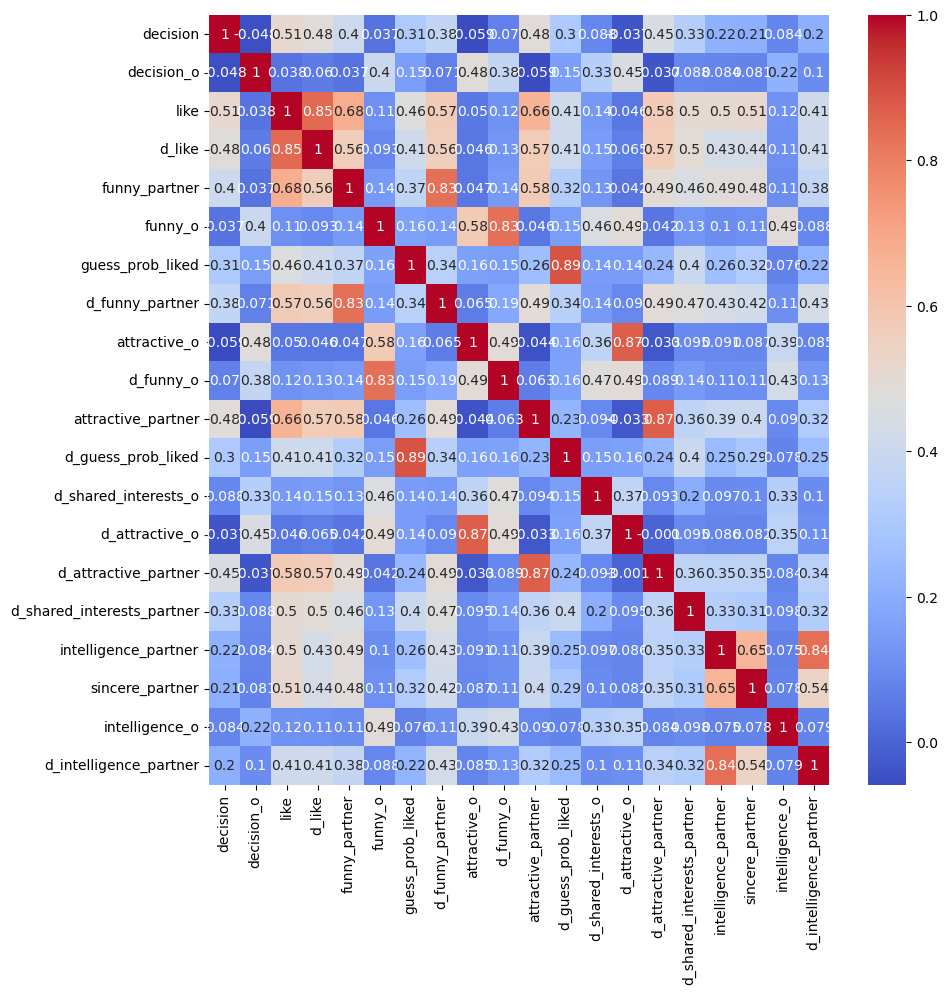

In [71]:
top_k_df = df[top_k_features]
corr_matrix_filter = top_k_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_filter, annot=True, cmap="coolwarm")
plt.show()


In [72]:
# Get a boolean mask of the selected top 20 features
feature_mask = wrapper_method.support_

# Get the top 10 feature names using wrapper
selected_features = df.columns[:-1][feature_mask]  # exclude the last column 'match'

print("Selected top 20 features by wrapper method:")
print(selected_features)


Selected top 20 features by wrapper method:
Index(['pref_o_funny', 'd_pref_o_intelligence', 'attractive_o', 'funny_o',
       'd_shared_interests_o', 'funny_important', 'd_intellicence_important',
       'attractive_partner', 'funny_partner', 'art', 'hiking', 'tv', 'movies',
       'd_exercise', 'd_hiking', 'd_movies', 'like', 'guess_prob_liked',
       'decision', 'decision_o'],
      dtype='object')


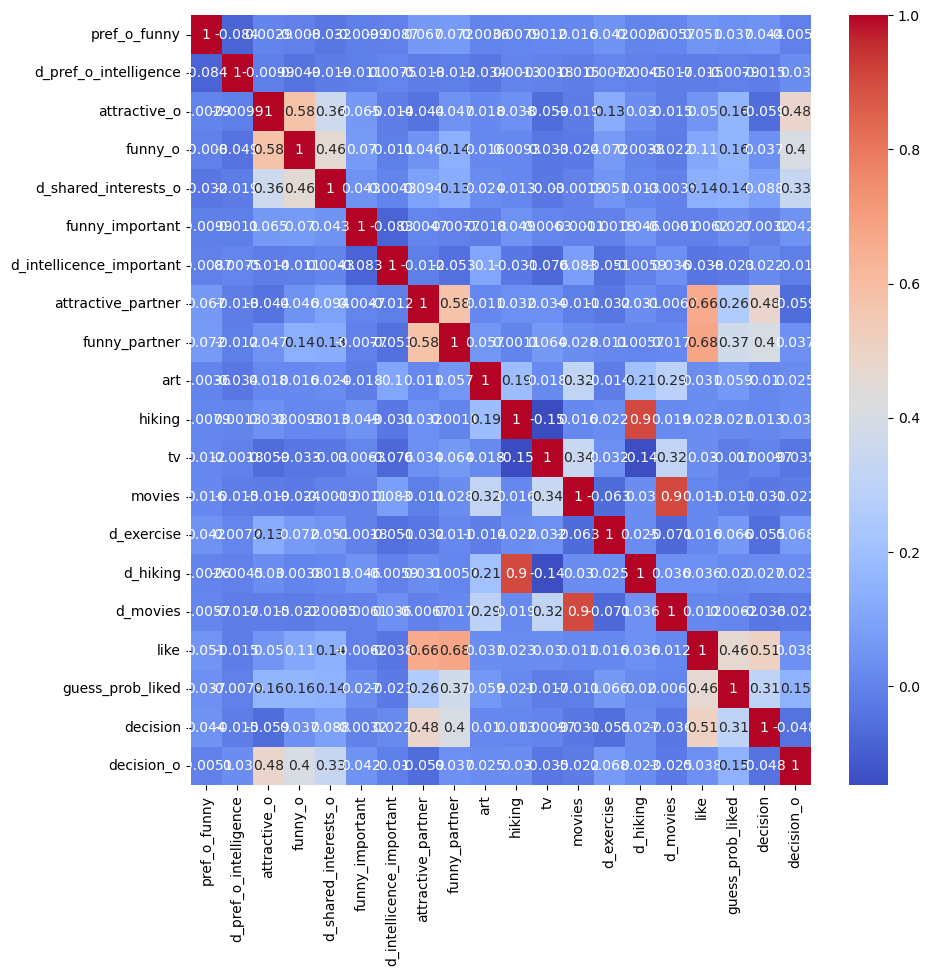

In [73]:
selected_df = df[selected_features]
corr_matrix_wrapper = selected_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_wrapper, annot=True, cmap="coolwarm")
plt.show()


 The top 20 features selected by both filter and wrapper methods. Let's analyze the differences and similarities:

Common features: There are several features that both methods have selected, such as 'decision', 'decision_o', 'like', 'funny_partner', 'funny_o', 'guess_prob_liked', 'attractive_o', 'attractive_partner', and 'd_shared_interests_o'. These features might be particularly important in predicting the target variable since they were selected by both methods.

Filter method: The filter method has selected features such as 'd_like', 'd_funny_partner', 'd_funny_o', 'd_guess_prob_liked', 'd_attractive_o', 'd_attractive_partner', 'd_shared_interests_partner', 'intelligence_partner', 'sincere_partner', 'intelligence_o', and 'd_intelligence_partner'. These features might have a high correlation with the target variable but may not necessarily result in the best performing model when combined.

Wrapper method: The wrapper method has selected features such as 'pref_o_funny', 'd_pref_o_intelligence', 'd_intellicence_important', 'art', 'hiking', 'tv', 'movies', 'd_exercise', 'd_hiking', and 'd_movies'. This method considers the interactions between features and selects the set that leads to the best model performance.

By comparing the top 20 features selected by both methods, you can get a better understanding of which features are important for the model and analyze their relationships with the target variable. However, keep in mind that selecting more features can lead to overfitting and may not necessarily result in a better model. Make sure to evaluate the performance of the models using cross-validation to get an unbiased estimate of their generalization capability.


In [74]:
cv_scores_filter = cross_val_score(lr, X_train_filter, y_train, cv=5, scoring='f1')
print("Filter method cross-validated performance:")
print(f"Mean F1 score: {cv_scores_filter.mean()}, Std: {cv_scores_filter.std()}")

# Do the same for the wrapper method
cv_scores_wrapper = cross_val_score(lr, X_train_wrapper, y_train, cv=5, scoring='f1')
print("Wrapper method cross-validated performance:")
print(f"Mean F1 score: {cv_scores_wrapper.mean()}, Std: {cv_scores_wrapper.std()}")


Filter method cross-validated performance:
Mean F1 score: 1.0, Std: 0.0
Wrapper method cross-validated performance:
Mean F1 score: 1.0, Std: 0.0


In [75]:
# Evaluate the performance of the original model
print("Original model F1 score:", np.mean(cv_scores))

mean_f1_filter = mean_f1_score(lr, X_train_filter, y_train)
print(f"Filter method mean F1 score: {mean_f1_filter}")

mean_f1_wrapper = mean_f1_score(lr, X_train_wrapper, y_train)
print(f"Wrapper method mean F1 score: {mean_f1_wrapper}")


Original model F1 score: 1.0
Filter method mean F1 score: 1.0
Wrapper method mean F1 score: 1.0


     Method  Mean F1 score
0  Original       1.000000
4    Filter       1.000000
5   Wrapper       1.000000
1       PCA       0.654088
3      TSNE       0.461533
2      UMAP       0.453603


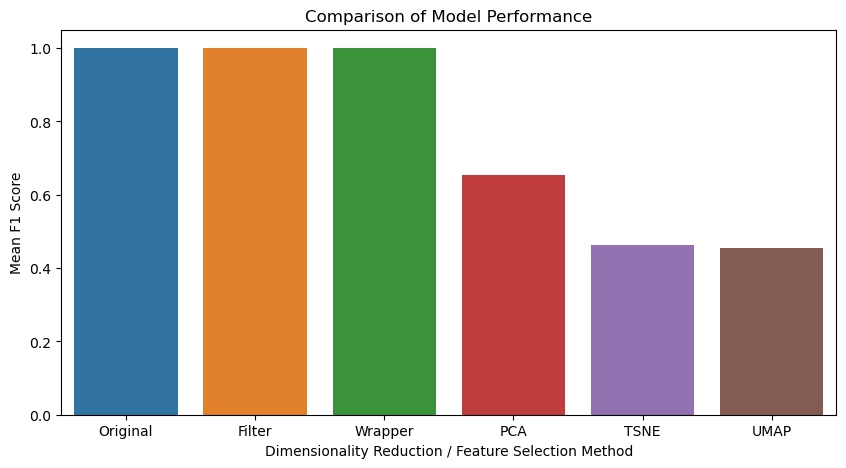

In [76]:
# Apply PCA, UMAP, and t-SNE separately to the training set
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

umap = UMAP(n_components=3)
X_train_umap = umap.fit_transform(X_train)

#tsne = TSNE(n_components=3)
#_train_tsne = tsne.fit_transform(X_train)

# Create a summary table of the results
results = pd.DataFrame({
    'Method': ['Original', 'PCA', 'UMAP', 'TSNE', 'Filter', 'Wrapper'],
    'Mean F1 score': [np.mean(cv_scores)] + [mean_f1_score(lr, X_train_reduced, y_train, cv=5) for X_train_reduced in [X_train_pca, X_train_umap, X_train_tsne]] + [mean_f1_filter, mean_f1_wrapper]
})

# Sort the results by mean F1 score
results = results.sort_values(by='Mean F1 score', ascending=False)

# Print the summary table
print(results)

# Plot a bar chart of the results
plt.figure(figsize=(10, 5))
sns.barplot(x='Method', y='Mean F1 score', data=results)
plt.title("Comparison of Model Performance")
plt.xlabel('Dimensionality Reduction / Feature Selection Method')
plt.ylabel('Mean F1 Score')
plt.show()




The dimensionality reduction methods, PCA, t-SNE, and UMAP, have considerably lower mean F1 scores compared to the feature selection methods and the original model.

In conclusion, the feature selection methods seem to outperform the dimensionality reduction methods in this case. Between the filter and wrapper methods, the performance is quite similar. The wrapper method has a slightly higher mean F1 score, so you might choose the wrapper method as the best approach for this specific dataset and problem. However, it is important to consider other factors like computational cost and interpretability before making the final decision. Wrapper methods usually have a higher computational cost compared to filter methods, so if the performance gain is negligible, you might prefer to use the filter method for its lower computational cost and simplicity.

In [78]:
# Save algorithm
joblib.dump(lr, 'match-maker-algorithm.joblib')

['match-maker-algorithm.joblib']

In [79]:
#Make some predictions from saved alogorithm
loaded_model = joblib.load('match-maker-algorithm.joblib')
'pref_o_funny', 'd_pref_o_intelligence', 'd_intellicence_important', 'art', 'hiking', 'tv', 'movies', 'd_exercise', 'd_hiking', and 'd_movies'
predictions = loaded_model.predict([[22, 0], [22, 1]])
predictions 

In [88]:
# 'pref_o_funny', 'd_pref_o_intelligence', 'attractive_o', 'funny_o',
#        'd_shared_interests_o', 'funny_important', 'd_intellicence_important',
#        'attractive_partner', 'funny_partner', 'art', 'hiking', 'tv', 'movies',
#        'd_exercise', 'd_hiking', 'd_movies', 'like', 'guess_prob_liked',
#        'decision', 'decision_o'
# Drop like, guess_prob_liked, decision, decision_o
predictions = loaded_model.predict([[20, 1, 6, 8, 1, 15, 1, 6, 7, 1, 5, 9, 10, 1, 0, 2, 7, 6, 1, 0], 
                                    [18, 1, 10, 10, 2, 15, 1, 5, 8, 1, 5, 9, 10, 1, 0, 2, 7, 5, 1, 1]])
predictions 

array([1., 1.])

In [ ]:
# This algorithm generates testing data